___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.researchgate.net/publication/331474581/figure/fig1/AS:1131188974567432@1646707876257/A-unified-deep-learning-framework-for-time-series-classification.png" width="500px" height="300px" />


# <font color= #8A0829> Clasificación de series de tiempo modelado.</font>

<Strong> Objetivos </Strong>
- Cómo desarrollar modelos de aprendizaje automático no lineales y de conjunto a partir de datos de acelerómetros con características de ingeniería específicas del dominio.
- Cómo desarrollar y evaluar un conjunto de modelos de redes neuronales convolucionales CNN para el reconocimiento de la actividad humana a partir de datos de acelerómetros.
- Cómo desarrollar y evaluar un conjunto de modelos de redes neuronales LSTM para el reconocimiento de la actividad humana a partir de datos de acelerómetros.

> Referencias:
    > - https://towardsdatascience.com/time-series-classification-with-deep-learning-d238f0147d6f
    > - https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
    > - Capítulo 22 de [Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
___

# Introducción a la función de pérdida Cross-Entropy para la clasificación de series de tiempo

La función de pérdida de entropía cruzada es una función de pérdida que se utiliza en problemas de clasificación. La entropía cruzada es una medida de la diferencia entre dos distribuciones de probabilidad. La entropía cruzada se utiliza para medir la diferencia entre la distribución de probabilidad real y la distribución de probabilidad estimada.

Inicialmente vamos a recordar la interpretación de la función de activación `softmax` para las capas de salida de mis redes neuronales. Veamos el siguiente ejemplo para enterlo:

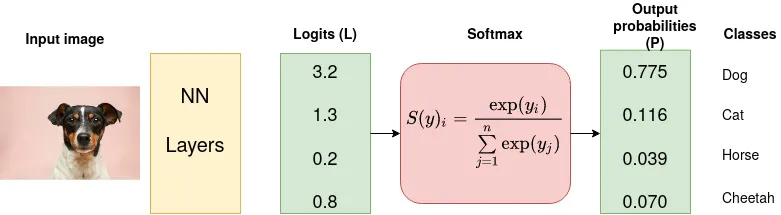

Con se puede observar `Softmax` convierte logits en probabilidades. El propósito de la entropía cruzada es tomar las probabilidades de salida (P) y medir la distancia desde los valores de verdad (como se muestra en la figura siguiente).

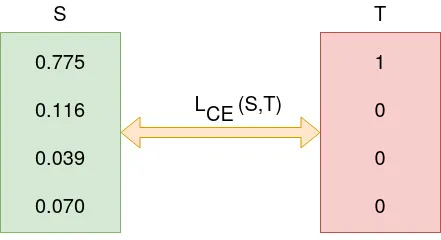

El objetivo es hacer que la salida del modelo sea lo más cercana posible a la salida deseada (valores de verdad). Durante el entrenamiento del modelo, los pesos del modelo se ajustan iterativamente en consecuencia con el objetivo de minimizar la pérdida de entropía cruzada.

En la siguiente figura se puede ver la definición formal de entropía:
Para una distribución de probabilidad `$p(x)$` de una variable aleatoria X la entropía se define cómo:
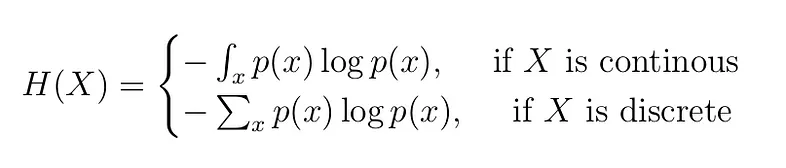

La entropía de una variable aleatoria X es el nivel de incertidumbre inherente al posible resultado de las variables.

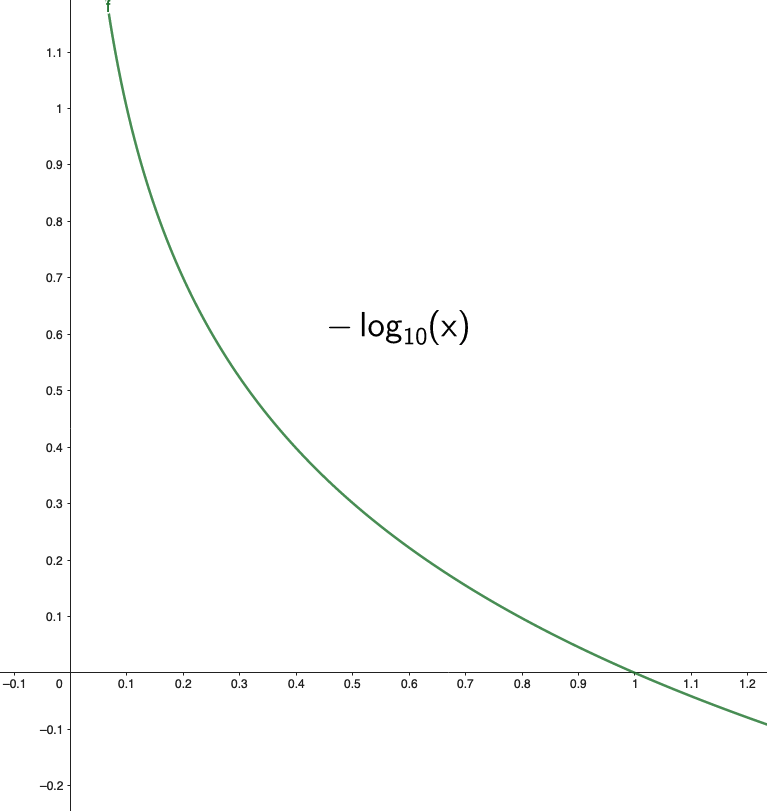

## Cross-Entropy Loss Function
También llamada pérdida logarítmica o pérdida logística. Cada probabilidad de clase predicha se compara con la salida deseada 0 o 1 de la clase real y se calcula una puntuación/pérdida que penaliza la probabilidad en función de qué tan lejos está del valor esperado real. La penalización es de naturaleza logarítmica y produce **una puntuación grande para diferencias grandes cercanas a 1 y una puntuación pequeña para diferencias pequeñas que tienden a 0.**

La pérdida de entropía cruzada se usa cuando se ajustan los pesos de los modelos durante el entrenamiento. El objetivo es minimizar la pérdida, es decir, cuanto menor sea la pérdida, mejor será el modelo. Un modelo perfecto tiene una pérdida de entropía cruzada de 0.

Cross-entropy se define como 
![imagen-4.png](attachment:imagen-4.png)

### Binary Cross-Entropy Loss

Para el caso cuando se tiene sólo dos clases la cross-entropy queda definida como:

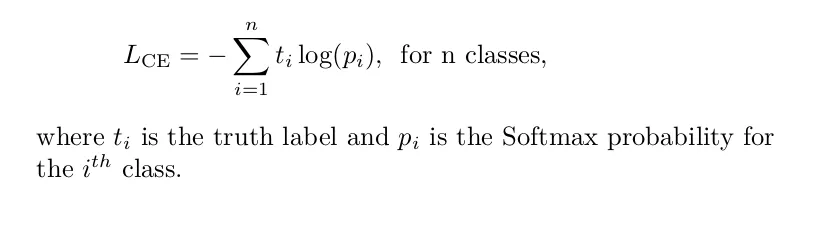

La entropía cruzada binaria a menudo se calcula como la entropía cruzada promedio en todos los ejemplos de datos, es decir,
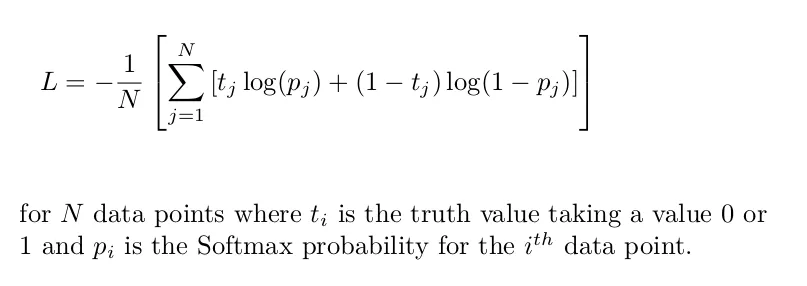

**Ejemplo:**
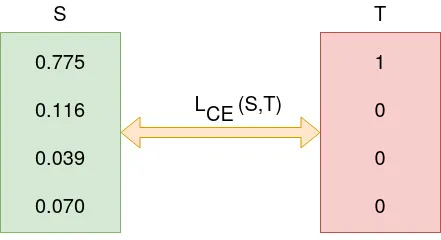
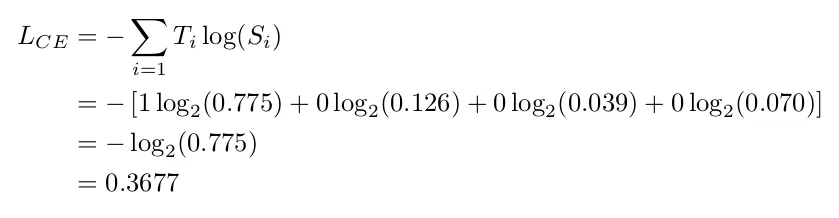

Después de algunas iteraciones al entrenar el modelo el resultado queda:
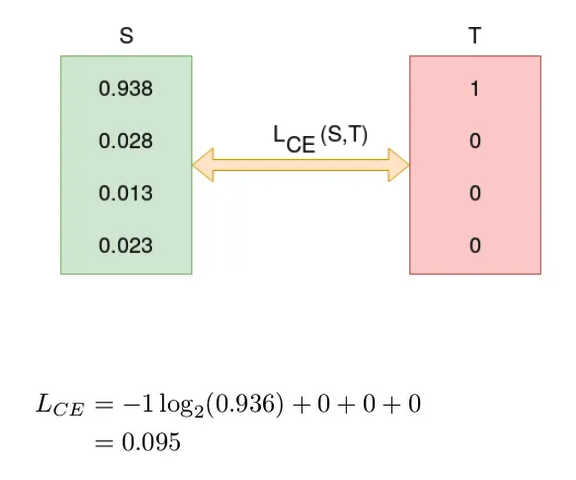

### Categorical Cross-Entropy and Sparse Categorical Cross-Entropy
Tanto la Categorical Cross-Entropy como la Sparse Categorical Cross-Entropy tienen la misma función de pérdida definida previamente. La única diferencia entre las dos es cómo se definen las etiquetas de verdad.

- La entropía cruzada categórica se usa cuando las etiquetas verdaderas están one-hot encoded, por ejemplo, tenemos los siguientes valores verdaderos para el problema de clasificación de 3 clases [1,0,0], [0,1,0] y [0,0 ,1].
- En la Sparse Categorical Cross-Entropy, las etiquetas de verdad están codificadas en números enteros, por ejemplo, [1], [2] y [3] para un problema de 3 clases.

> Referencia: https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

Luego de entender el significado matemático de la función de pérdida **cross-entropy** para problemas de clasificación, podemos continuar analizando nuestros datos.

En la clase anterior realizamos una exploración y análisis de los datos de HAR, ahora vamos a proceder a modelar dichos datos para poder realizar una clasificación de series de tiempo para la predicción de la actividad humana. Para ello, vamos a utilizar el mismo set de datos estudiados la clase anterior.

In [1]:
# Importar librerías
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
import matplotlib.pyplot as plt
from keras.layers import Dense
import seaborn as sns
import pandas as pd
import numpy as np
import os

2023-03-30 19:17:56.402864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Crear función que lee los datos de un archivo en formato txt y los retorna en un dataframe. Están separados por espacios en blanco
def load_file(filename):
    df = pd.read_csv(filename, delim_whitespace=True, header=None)
    return df.values

# Crear función que lee los datos de entrenamiento y de prueba
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + f) for f in filenames]

    # Apilar los datos en un solo array de 3 dimensiones
    loaded = np.dstack(loaded)
    return loaded

# Crear función que lee los datos de entrenamiento y de prueba
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # cargar los 9 archivos como un único array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_' + group + '.txt', 'total_acc_y_' + group + '.txt',
                  'total_acc_z_' + group + '.txt']
    # body acceleration
    filenames += ['body_acc_x_' + group + '.txt', 'body_acc_y_' + group + '.txt',
                  'body_acc_z_' + group + '.txt']
    # body gyroscope
    filenames += ['body_gyro_x_' + group + '.txt', 'body_gyro_y_' + group + '.txt',
                  'body_gyro_z_' + group + '.txt']
    # cargar input data
    X = load_group(filenames, filepath)
    # cargar class output
    y = load_file(prefix + group + '/y_' + group + '.txt')
    return X, y

In [3]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # Cargo los datos de entrenamiento
    trainX, trainy = load_dataset_group('train', prefix)
    print('datos de entrenamiento', trainX.shape, trainy.shape, sep='\n')
    # Cargo los datos de prueba
    testX, testy = load_dataset_group('test', prefix)
    print('datos de prueba',testX.shape, testy.shape, sep='\n')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print('datos luegos del one-hote encode', trainX.shape, trainy.shape, testX.shape, testy.shape, sep='\n')
    return trainX, trainy, testX, testy

```python
trainy = [5, 5, 5, ..., 2, 2, 2]
to_categorical(trainy)
array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)
```

In [5]:
# Cargar los datos de entrenamiento y de prueba
trainX, trainy, testX, testy = load_dataset('UCI HAR Dataset/')

datos de entrenamiento
(7352, 128, 9)
(7352, 1)
datos de prueba
(2947, 128, 9)
(2947, 1)
datos luegos del one-hote encode
(7352, 128, 9)
(7352, 6)
(2947, 128, 9)
(2947, 6)


## Modelado de datos

La primera consideración importante es el planteamiento del problema de predicción. El marco del **problema**, tal y como se describe en el trabajo original, es la **predicción de la actividad de un nuevo sujeto a partir de sus datos de movimiento, basándose en los datos de movimiento y las actividades de sujetos conocidos.** Podemos resumirlo así:
- **Predecir la actividad a partir de una ventana de datos de movimiento.**
Además de la ventana de datos de movimientos, también su pudiera analizar los siguientes casos:
- Predecir la actividad a partir de un paso temporal de datos de movimiento.
- Predecir la actividad a partir de varias ventanas de datos de movimiento.
- Predecir la secuencia de actividad dadas múltiples ventanas de datos de movimiento.
- Predecir la actividad dada una secuencia de datos de movimiento para una actividad pre-segmentada.
- Predecir el cese o transición de la actividad dado un paso de tiempo de datos de movimiento.
- Predecir una actividad estacionaria o no estacionaria dada una ventana de datos de movimiento.

Toda esta gama de problemas nos muestran un panorama definido del tipo de problema que estamos tratando de resolver. **En este caso, vamos a tratar de predecir la actividad a partir de una ventana de datos de movimiento**. Esto significa que vamos a tratar de predecir la actividad de un sujeto a partir de una ventana de datos de movimiento de 2.56 segundos, con una superposición de 50% entre ventanas. Esto significa que cada ventana de datos de movimiento contiene 128 lecturas de acelerómetro y giroscopio. Cada lectura contiene 9 valores, uno para cada eje de aceleración y giroscopio. Esto significa que cada ventana de datos de movimiento contiene 1152 (128*9) valores de entrada. La salida es un valor entero entre 1 y 6 que representa la actividad que se está realizando en la ventana de datos de movimiento.

### Preparación de datos

Como se mencionó en la clase anterior los datos de los sensores ya se encuentran escalados en un intervalor [-1, 1]. Además, algunas transformaciones adicionales se pudieran realizar en los datos de los sensores para mejorar la representación de los datos. Estas transformaciones incluyen:
- Normalización entre sujetos.
- Normalización por sujeto.
- Estandarización entre sujetos.
- Selección de características del tipo de datos.
- Detección y eliminación de señales atípicas.
- Eliminación de ventanas de actividades sobrerrepresentadas.
- Sobremuestreo de ventanas de actividades infrarrepresentadas.
- Reducción del muestreo de los datos de la señal a $1/4$, $1/2$, 1, 2 u otras fracciones de una sección.

# 1. Cómo desarrollar CNN para Human Activity Recognition

En esta sección abordaremos el problema de clasificación de seres de tiempo de Human Activity Recognition (HAR) utilizando una red neuronal convolucional unidimensional (CNN1D). El conjunto de datos que usaremos es el conjunto de datos de reconocimiento de la actividad humana de UCI, que contiene datos de movimiento de 30 sujetos mientras realizan 6 actividades diferentes. Los objetivos serán:
- Cómo cargar y preparar los datos para un conjunto de datos estándar de reconocimiento de la actividad humana y desarrollar un único modelo CNN 1D que logre un rendimiento excelente en los datos brutos.
- Cómo ajustar aún más el rendimiento del modelo, incluyendo la transformación de los datos, los mapas de filtros y los tamaños de los kernels.
- Cómo desarrollar un sofisticado modelo de red neuronal convolucional unidimensional multicabezal (multi-headed one-dimensional convolutional neural network) que proporcione un resultado similar al de un conjunto.

## 1.1 Ajuste y evaluación del modelo

La salida del modelo será un vector de seis elementos que contendrá la probabilidad de que una ventana determinada pertenezca a cada uno de los seis tipos de actividad. Estas dimensiones de entrada y salida son necesarias para ajustar el modelo, y podemos extraerlas del conjunto de datos de entrenamiento proporcionado


In [7]:
# Definición de la arquitectura del modelo
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
n_timesteps, n_features, n_outputs

(128, 9, 6)

Para construir el modelo vamos usar las siguientes capas:
- Capa de entrada: 1D convolución con 64 filtros y un tamaño de kernel de 3.
- Capa oculta: 1D convolución con 64 filtros y un tamaño de kernel de 3.
- Capa de salida: Capa de clasificación con 6 neuronas y función de activación softmax para la predicción de la probabilidad de cada clase.
- Función de pérdida: categorical_crossentropy.
- Optimizador: adam.
- Métrica: accuracy.
- Dropout: 0.5
- Pooling: MaxPooling1D
- Flatten: Flatten

También vamos usar la función de activación relu en las capas ocultas.

Por otro lado se entrenará para 10 épocas y un tamaño de lote de 32. Donde `batch size` es el número de muestras que se propagarán a través de la red antes de que se actualicen los pesos. El tamaño del lote es un hiperparámetro que se puede ajustar para mejorar el rendimiento del modelo.

In [34]:
# Definir el modelo CNN
def define_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
# Ajustar y evaluar el modelo
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    # Definición de la arquitectura del modelo
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = define_model()
    # Ajustar el modelo
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # Evaluar el modelo
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [54]:
# Repetir la evaluación del modelo
def repeat_evaluate_model(trainX, trainy, testX, testy, n_repeats=10):
    scores = list()
    for i in range(n_repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>%d: %.3f' % (i+1, score))
        scores.append(score)
    return scores

In [55]:
# Resumen de los resultados
def summarize_results(n_repeats):
    # Ejecutar la evaluación del modelo
    scores = repeat_evaluate_model(trainX, trainy, testX, testy, n_repeats)
    # Imprimir el resumen
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [40]:
# Ejecutar el experimento
def run_experiment(n_repeats):
    # Cargar los datos
    trainX, trainy, testX, testy = load_dataset('UCI HAR Dataset/')

    # Resumir los resultados
    summarize_results(n_repeats)

In [41]:
# Ejecutar el experimento
n_repeats = 30
run_experiment(n_repeats)

datos de entrenamiento
(7352, 128, 9)
(7352, 1)
datos de prueba
(2947, 128, 9)
(2947, 1)
datos luegos del one-hote encode
(7352, 128, 9)
(7352, 6)
(2947, 128, 9)
(2947, 6)


2023-03-30 13:05:36.265269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


>1: 90.533
>2: 90.770
>3: 90.295
>4: 90.465
>5: 90.906
>6: 89.990
>7: 91.076
>8: 92.094
>9: 89.752
>10: 91.449
>11: 89.515
>12: 90.804
>13: 91.313
>14: 91.110
>15: 91.313
>16: 87.411
>17: 90.533
>18: 90.668
>19: 91.483
>20: 90.974
>21: 90.159
>22: 91.110
>23: 89.684
>24: 89.752
>25: 85.171
>26: 91.110
>27: 91.381
>28: 90.770
>29: 90.635
>30: 89.549
[90.53274393081665, 90.77027440071106, 90.29521346092224, 90.46487808227539, 90.90600609779358, 89.98982310295105, 91.07567071914673, 92.09365248680115, 89.75229263305664, 91.44893288612366, 89.51476216316223, 90.80420732498169, 91.31320118904114, 91.10960364341736, 91.31320118904114, 87.41092681884766, 90.53274393081665, 90.66847562789917, 91.48286581039429, 90.97387194633484, 90.15948176383972, 91.10960364341736, 89.68442678451538, 89.75229263305664, 85.17135977745056, 91.10960364341736, 91.3810670375824, 90.77027440071106, 90.63454270362854, 89.54869508743286]
Accuracy: 90.392% (+/-1.295)


## 1.2 Ajuste del modelo

### 1.2.1 Transformación de los datos
Como vimos en la clase anterior los datos se encuentran esclados en el rango [-1, 1], pero no es claro si esta transformación fue realizada por sujeto o para todo el conjunto de datos. Podemos probar si la transformación de los datos mejora el rendimiento del modelo. Antes de esto, debemos recordar que para realizar un escalamiento, necesitamos tener los datos sin procesar, es decir sin el 50% de overlap entre ventanas. Para esto vamos a usar numpy para realizar la transformación de los datos.

In [42]:
# Remover el overlap
cut = int(trainX.shape[1] / 2)
longX = trainX[:, -cut:, :]

# flatten windows
longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))

longX.shape

(470528, 9)

In [46]:
# Graficar la distribución de las variables
def plot_variable_distributions(trainX):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    plt.figure(figsize=(10, 10))
    for i in range(longX.shape[1]):
        # create figure
        ax = plt.subplot(longX.shape[1], 1, i+1)
        ax.set_xlim(-1, 1)
        # create histogram
        plt.hist(longX[:, i], bins=100)
        # simplify axis remove clutter
        plt.yticks([])
        plt.xticks([-1,0,1])
    plt.show()

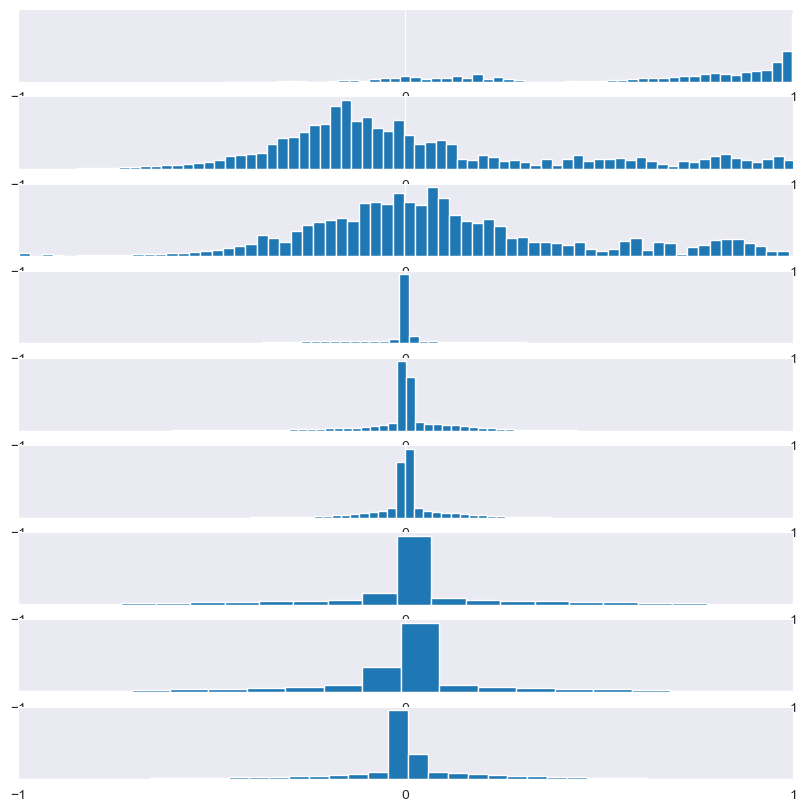

In [47]:
# plot histograms
plot_variable_distributions(trainX)

Vemos que en la mayoría de las variables la distribución es similar a la distribución normal, pero hay algunas variables que tienen una distribución diferente. Por ejemplo, la variable 1 y 2 tienen una distribución diferente a la normal. Por otro lado, la variable 3 tiene una distribución similar a la normal, pero con una cola más larga. Por lo tanto, podemos probar si la transformación de los datos mejora el rendimiento del modelo.

Ahora vamos a crear una función que estandarice nuestros datos. Para esto vamos a usar la función `StandardScaler` de la librería `sklearn.preprocessing`. Esta función estandariza los datos, es decir, los datos se transforman de tal manera que la media de los datos sea 0 y la desviación estándar sea 1. Para esto, se realiza la siguiente transformación:

In [52]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

In [50]:
# standardize data
def scale_data(trainX, testX, standardize):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]

    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))

    # flatten train and test
    flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
    flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

    # standardize
    if standardize:
        s = StandardScaler()
        # fit on training data
        s.fit(longX)
        # apply to training and test data
        longX = s.transform(longX)
        flatTrainX = s.transform(flatTrainX)
        flatTestX = s.transform(flatTestX)
    # reshape
    flatTrainX = flatTrainX.reshape((trainX.shape))
    flatTestX = flatTestX.reshape((testX.shape))
    return flatTrainX, flatTestX

Vamos a introducir este escalamiento en la función `evaluate_model` y vamos a probar si mejora el rendimiento del modelo.

In [48]:
# Ajustar y evaluar el modelo
def evaluate_model(trainX, trainy, testX, testy, scale=True):
    verbose, epochs, batch_size = 0, 10, 32
    # Definición de la arquitectura del modelo
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    if scale:
        trainX, testX = scale_data(trainX, testX, True)

    model = define_model()
    # Ajustar el modelo
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # Evaluar el modelo
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [53]:
# Ejecutar el experimento
n_repeats = 10
run_experiment(n_repeats)

datos de entrenamiento
(7352, 128, 9)
(7352, 1)
datos de prueba
(2947, 128, 9)
(2947, 1)
datos luegos del one-hote encode
(7352, 128, 9)
(7352, 6)
(2947, 128, 9)
(2947, 6)
>1: 92.263
>2: 92.535
>3: 91.381
>4: 92.433
>5: 92.976
>6: 90.397
>7: 91.788
>8: 90.838
>9: 92.331
>10: 91.585
>11: 92.094
>12: 92.535
>13: 91.313
>14: 91.653
>15: 90.465
>16: 90.736
>17: 91.110
>18: 91.313
>19: 90.838
>20: 91.754
>21: 92.365
>22: 91.279
>23: 91.415
>24: 92.874
>25: 90.227
>26: 91.686
>27: 92.026
>28: 89.990
>29: 89.650
>30: 92.467
[92.2633171081543, 92.53478050231934, 91.3810670375824, 92.43298172950745, 92.97590851783752, 90.39701223373413, 91.78826212882996, 90.83814024925232, 92.33118295669556, 91.58466458320618, 92.09365248680115, 92.53478050231934, 91.31320118904114, 91.65253043174744, 90.46487808227539, 90.73634147644043, 91.10960364341736, 91.31320118904114, 90.83814024925232, 91.75432920455933, 92.36511588096619, 91.27926826477051, 91.41499996185303, 92.87410974502563, 90.22734761238098, 91.

### 1.2.2 Ajuste de hiperparámetros

Queda cómo **ejercicio** ajustar los hiperparámetros del modelo para mejorar el rendimiento del modelo. Para esto, vamos a crear una función que nos permita ajustar los hiperparámetros del modelo. Para esto, vamos a usar `optuna`.

## 1.3 Multi-headed CNN model
Para este cao vamos a usar una CNN con tres cabezas. Cada cabeza va a tener una capa de convolución con diferentes tamaños de ventana. Luego, cada cabeza va a tener una capa de pooling y una capa de dropout. Finalmente, las tres cabezas se van a concatenar y se va a agregar una capa densa para la clasificación. La arquitectura del modelo es la siguiente:


In [58]:
# Import librarias faltantes
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Dense, Flatten, Dropout, Conv1D, MaxPooling1D, concatenate
from keras.models import Model

In [56]:
# Ajustar y evaluar el modelo multi-headed CNN
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(64, 3, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D()(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(64, 5, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D()(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(64, 11, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D()(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multiheaded.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size,
              verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
    return accuracy

In [59]:
# Ejecutar el experimento
n_repeats = 10
run_experiment(n_repeats)

datos de entrenamiento
(7352, 128, 9)
(7352, 1)
datos de prueba
(2947, 128, 9)
(2947, 1)
datos luegos del one-hote encode
(7352, 128, 9)
(7352, 6)
(2947, 128, 9)
(2947, 6)
>1: 91.517
>2: 90.974
>3: 92.603
>4: 93.010
>5: 93.213
>6: 91.144
>7: 90.261
>8: 93.213
>9: 90.329
>10: 91.890
[91.51679873466492, 90.97387194633484, 92.6026463508606, 93.00984144210815, 93.21343898773193, 91.14353656768799, 90.26128053665161, 93.21343898773193, 90.32914638519287, 91.89005494117737]
Accuracy: 91.815% (+/-1.088)


# Ajuste de hiperparámetros

In [12]:
import pandas as pd
import tensorflow as tf
import optuna

def objective(trial):

    # Definir los hiperparámetros a ajustar
    batch_size = 32
    filters1 = trial.suggest_int('filters', 32, 128)
    filters2 = trial.suggest_int('filters', 32, 128)
    kernel_size = trial.suggest_int('kernel_size', 3, 11)
    
    num_neurons = trial.suggest_int('num_neurons', 16, 256)
    dropout_rate = trial.suggest_float('rate', 0.0, 0.7)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    epochs = trial.suggest_int('epochs', 10, 200)
    
    # Crear el modelo de TensorFlow
    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=kernel_size, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=filters2, kernel_size=kernel_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    
    # Compilar el modelo con los hiperparámetros ajustados
    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])

    # Entrenar el modelo y obtener el error de validación
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size,
              verbose=0)
    
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

    return accuracy

# Definir el objeto de estudio de Optuna y ejecutar la búsqueda de hiperparámetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Imprimir los resultados
print('Best trial:', study.best_trial.params)
print('Best validation loss:', study.best_trial.value)


[I 2023-03-30 19:30:37,685] A new study created in memory with name: no-name-c11027a6-2ab9-4046-907f-ee5ba5687dcb
[W 2023-03-30 19:32:50,188] Trial 0 failed with parameters: {'filters': 127, 'kernel_size': 11, 'num_neurons': 147, 'rate': 0.38620368420761275, 'learning_rate': 0.04002378439256461, 'epochs': 50} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/f_/yfk7pckx1pvcrgw8dsns53yr0000gn/T/ipykernel_1924/3654514660.py", line 34, in objective
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size,
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
    tmp_logs = s

KeyboardInterrupt: 

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>